# Advection example

We consider a 2D periodic domain $[0;1]^2$

For a scalar field $\rho(\boldsymbol x, t)$ and a velocity vector field $\boldsymbol v(\boldsymbol x,t)$, the advection problem reads:

$$\frac{\partial{\rho(\boldsymbol x, t)}}{\partial{t}} + \boldsymbol v(\boldsymbol x,t).\nabla \rho(\boldsymbol x,t) = 0$$

with initial conditions

$$\boldsymbol v(\boldsymbol x,t) = (-\sin(\pi x)^2\sin(2\pi   y),\sin(2\pi x)\sin(\pi y)^2)$$

$$\rho(\boldsymbol x,0) = \exp(-(x-0.5)^2-(y-0.75)^2)$$

- $\boldsymbol x = [x,y]$ are the space coordinates, discretized with 128 points in each direction.
- $t$ the time from from t=0 to t=0.25


## Initialization
### Imports
First import all necessary elements from numpy and hysop

In [21]:
import numpy as np

In [22]:
from hysop import Field, Box, Simulation, Problem, ScalarParameter, IOParams
from hysop.constants import Implementation
from hysop.operators import Advection, DirectionalAdvection, StrangSplitting
from hysop.methods import Remesh, TimeIntegrator, StrangOrder
from hysop.numerics.odesolvers.runge_kutta import Euler, RK2, RK3, RK4, RK4_38
from hysop.core.mpi import default_mpi_params

### Domain
Let's define the computational domain

In [23]:
dim = 2
box = Box(origin=(0.0,) * dim, length=(1.0,) * dim, dim=dim)
print(box)

Box::d0 | 2D rectangular box domain:
  *origin:  [0. 0.]
  *max_pos: [1. 1.]
  *length:  [1. 1.]
  *left  boundary conditions: [PERIODIC(0), PERIODIC(0)]
  *right boundary conditions: [PERIODIC(0), PERIODIC(0)]



### Fields
Let's define fields and parameters

In [24]:
dt = ScalarParameter("dt")
velocity = Field(domain=box, name="V", is_vector=True)
scalar = Field(domain=box, name="S", nb_components=1)

### Operators
Let's define operators and the numerical parameters

In [25]:
# Discretization 
npts = (128,) * dim
# Numerical methods
method = {
    TimeIntegrator: RK2,
    Remesh: Remesh.L4_2,
}
# Constraints
cfl = 0.5 # here the cfl determines the maximum number of ghosts points for boundary conditions
# Set default MPI Parameters from domain (even for serial jobs)
mpi_params = default_mpi_params()

In [26]:
advec = DirectionalAdvection(
    # implementation=impl,
    name="advection",
    velocity=velocity,
    velocity_cfl=cfl,
    advected_fields=(scalar,),
    variables={velocity: npts, scalar: npts},
    dt=dt,
    mpi_params=mpi_params,
)

Note that this operator is solving the advection equation in a single direction in space. We need to specify how to combine all space directions, as an operator splitting.

In [27]:
splitting = StrangSplitting(splitting_dim=dim, 
                            order=StrangOrder.STRANG_FIRST_ORDER)
splitting.push_operators(advec)

### Problem
Gather all operators in a single problem to solve.

In [28]:
problem = Problem(method=method)
problem.insert(splitting)

Problem::node9

### Build all lower level stuff
Tell hysop to perform all lover level initializations (allocations, discretization of operators, numerical methods setup, ...)

In [29]:
problem.build()

### Initial conditions
Setup the initial conditions for this example in velocity and scalar.



In [30]:
# Function to compute initial velocity values
u0 = [lambda x,y: -np.sin(np.pi * x) ** 2 * np.sin(2 * np.pi * y),
      lambda x,y: np.sin(2 * np.pi * x) * np.sin(np.pi * y) ** 2]
def init_velocity(data, coords, component):
    x, y = coords
    data[...] = u0[component](x,y)

# Function to compute initial scalar values
s0 = lambda x,y: np.exp(-(((x - 0.5) ** 2) + (y - 0.75) ** 2)*100)+np.exp(-(((x - 0.5) ** 2) + (y - 0.25) ** 2)*100)
def init_scalar(data, coords, component):
    x, y = coords
    data[...] = s0(x,y)

problem.initialize_field(velocity, formula=init_velocity)
problem.initialize_field(scalar, formula=init_scalar)

### Setup time discretization
Enforce a time stepping from the prescribed CFL and the velocity field.

In [31]:
# Get the space step
dx = problem.get_input_discrete_field(scalar).space_step.min()
Vmax = np.max(np.abs(problem.get_input_discrete_field(velocity).data))
simu = Simulation(
    start=0.0,
    end=0.25,
    dt=dt, # parameter to store timestep
    dt0=(cfl * dx) / Vmax, # inital timestep value
)

## Solving the equation
Perform the time steps computations

In [32]:
problem.solve(simu)

## Post-process the solution
Here we are at time $t=0.25$. The solution is:


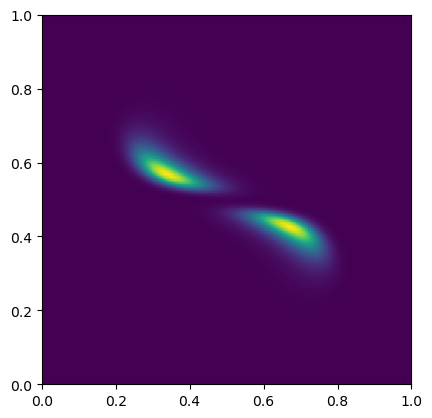

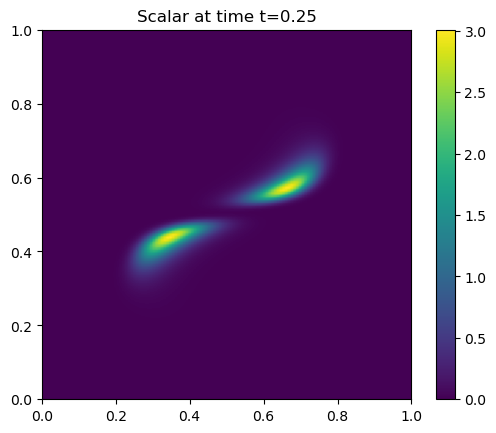

In [33]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
scalar_data = problem.get_input_discrete_field(scalar).data[0]
im = ax.imshow(
    scalar_data,
    extent=[0,1,0,1],origin='lower')
ax.set_title(f"Scalar at time t={simu.end}")
fig.colorbar(im, ax=ax)
plt.show()

Clean up memory

In [34]:
problem.finalize()

## Complements
For a more specific IO, one can tell to output files during simulation at every 10 time-steps including last solution.

In [35]:
problem = Problem(method=method)
problem.insert(splitting)
problem.dump_inputs(
    fields=scalar, var_names={scalar: "S"},
    io_params=IOParams(filename="S0", filepath=".", frequency=10, with_last=True),
    mpi_params=mpi_params,
)
problem.build()
problem.initialize_field(velocity, formula=init_velocity)
problem.initialize_field(scalar, formula=init_scalar)
problem.solve(simu)

In [36]:
import h5py
import glob
from matplotlib.animation import FuncAnimation
plt.rcParams["animation.html"] = "jshtml"
plt.ioff()

h5files = sorted(glob.glob('*.h5'))
fig, ax = plt.subplots()
im = ax.imshow(s0(*np.meshgrid(*problem.get_input_discrete_field(scalar).coords)),extent=[0,1,0,1])
def animate(t=0):  
    with h5py.File(h5files[t],'r') as h5:
        scalar_data = np.asarray(h5['S'])
    if t==0:
        im.set_data(scalar_data)
    else:
        ax.imshow(scalar_data,extent=[0,1,0,1], animated=True)
    return im,

FuncAnimation(fig, animate, init_func=animate, frames=len(h5files))